In [1]:
# Импорт всех необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Загрузка данных
data = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')

#Уберем Unnamed т.к. далее он мешает
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

# Переместим названия колонок в отдельную переменную, пригодится
columns = data.columns.tolist()

# Быстрая проверка
data.head()

,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0,0,0,0,0,0,0,0,0,0


Первичный EDA и базовые характеристики
---

In [2]:
# Проверим размеры и типы данных
print("Размер выборки:", data.shape)
print("\nТипы данных:")
print(data.dtypes)

# Проверим пропуски
print("\nКоличество пропущенных значений:")
print(data.isnull().sum())

# Основные статистики
display(data.describe())

Размер выборки: (1001, 213)

Типы данных:
IC50, mM             float64
CC50, mM             float64
SI                   float64
MaxAbsEStateIndex    float64
MaxEStateIndex       float64
                      ...   
fr_thiazole            int64
fr_thiocyan            int64
fr_thiophene           int64
fr_unbrch_alkane       int64
fr_urea                int64
Length: 213, dtype: object

Количество пропущенных значений:
IC50, mM             0
CC50, mM             0
SI                   0
MaxAbsEStateIndex    0
MaxEStateIndex       0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 213, dtype: int64


,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,...,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.0,1001.000000,1001.000000,1001.000000
mean,222.805156,589.110728,72.508823,10.831637,10.831637,0.180681,-0.967237,0.580412,29.487989,348.262234,...,0.053946,0.011988,0.008991,0.000999,0.000999,0.051948,0.0,0.069930,0.204795,0.006993
std,402.169734,642.867508,684.482739,3.307505,3.307505,0.168710,1.588036,0.212230,12.742749,126.946370,...,0.259011,0.108886,0.094441,0.031607,0.031607,0.222033,0.0,0.255157,1.215326,0.083373
min,0.003517,0.700808,0.011489,2.321942,2.321942,0.000039,-6.992796,0.059567,9.416667,110.156000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,12.515396,99.999036,1.433333,9.252350,9.252350,0.051073,-1.334487,0.442842,18.486486,264.321000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,46.585183,411.039342,3.846154,12.179236,12.179236,0.124606,-0.419485,0.634981,29.290323,315.457000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,224.975928,894.089176,16.566667,13.167843,13.167843,0.291020,0.061754,0.742483,38.750000,409.283000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,4128.529377,4538.976189,15620.600000,15.933463,15.933463,1.374614,1.374614,0.947265,60.272727,904.777000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,20.000000,1.000000


Распределения целевых переменных
---

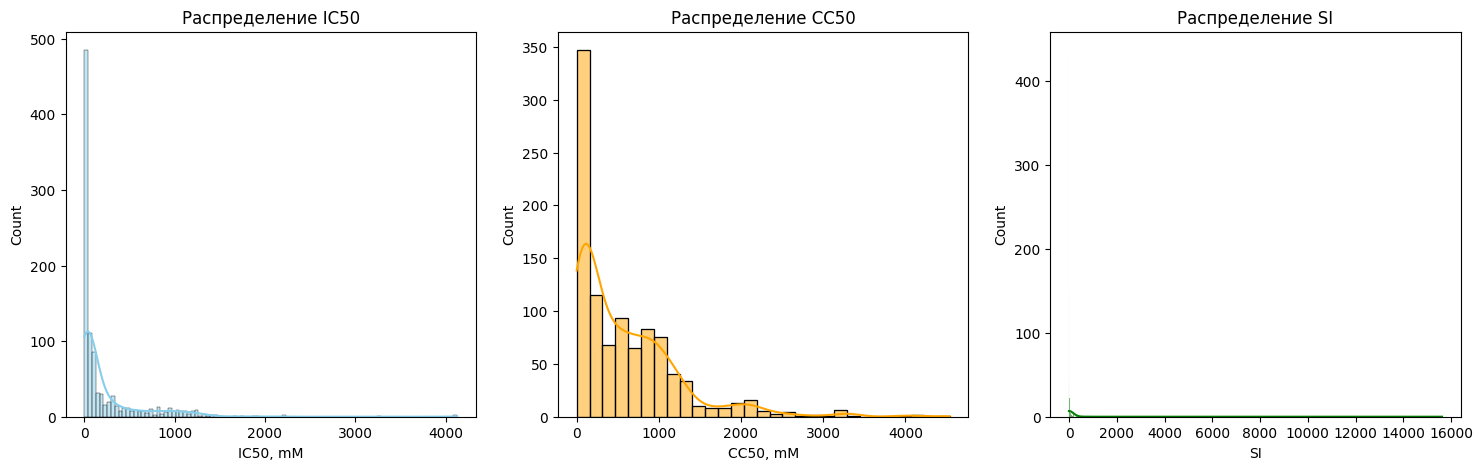

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(data['IC50, mM'], kde=True, ax=axs[0], color='skyblue')
axs[0].set_title('Распределение IC50')

sns.histplot(data['CC50, mM'], kde=True, ax=axs[1], color='orange')
axs[1].set_title('Распределение CC50')

sns.histplot(data['SI'], kde=True, ax=axs[2], color='green')
axs[2].set_title('Распределение SI')

plt.show()

---

Что происходит c IC50:
Ярко выраженный левый сдвиг: большинство значений находятся ближе к нулю.

Длинный правый хвост — есть соединения с крайне высокими значениями IC50.

Распределение сильно асимметрично (скошено вправо) — признак лог-нормального распределения.

Следствие для моделей:

В чистом виде регрессия (например, Linear Regression) может плохо работать.

Полезно рассмотреть логарифмическое преобразование log(IC50).

Лучше использовать более устойчивые модели: RandomForest, GradientBoosting и т.п.


---
Что происходит c CC50:
Очень похожая ситуация: скошенность вправо, длинный хвост.

Большинство наблюдений лежат в области малых значений.

Ещё сильнее выражен длинный хвост, чем у IC50.

Следствие для моделей:

Такая же история — полезно применить логарифмическое преобразование.

Важно следить за выбросами.


---
Что происходит c SI:
Тут вообще экстремально длинный хвост.

видим, что есть единичные наблюдения, где SI может быть > 10 000.

Основная масса данных сконцентрирована вблизи нуля.


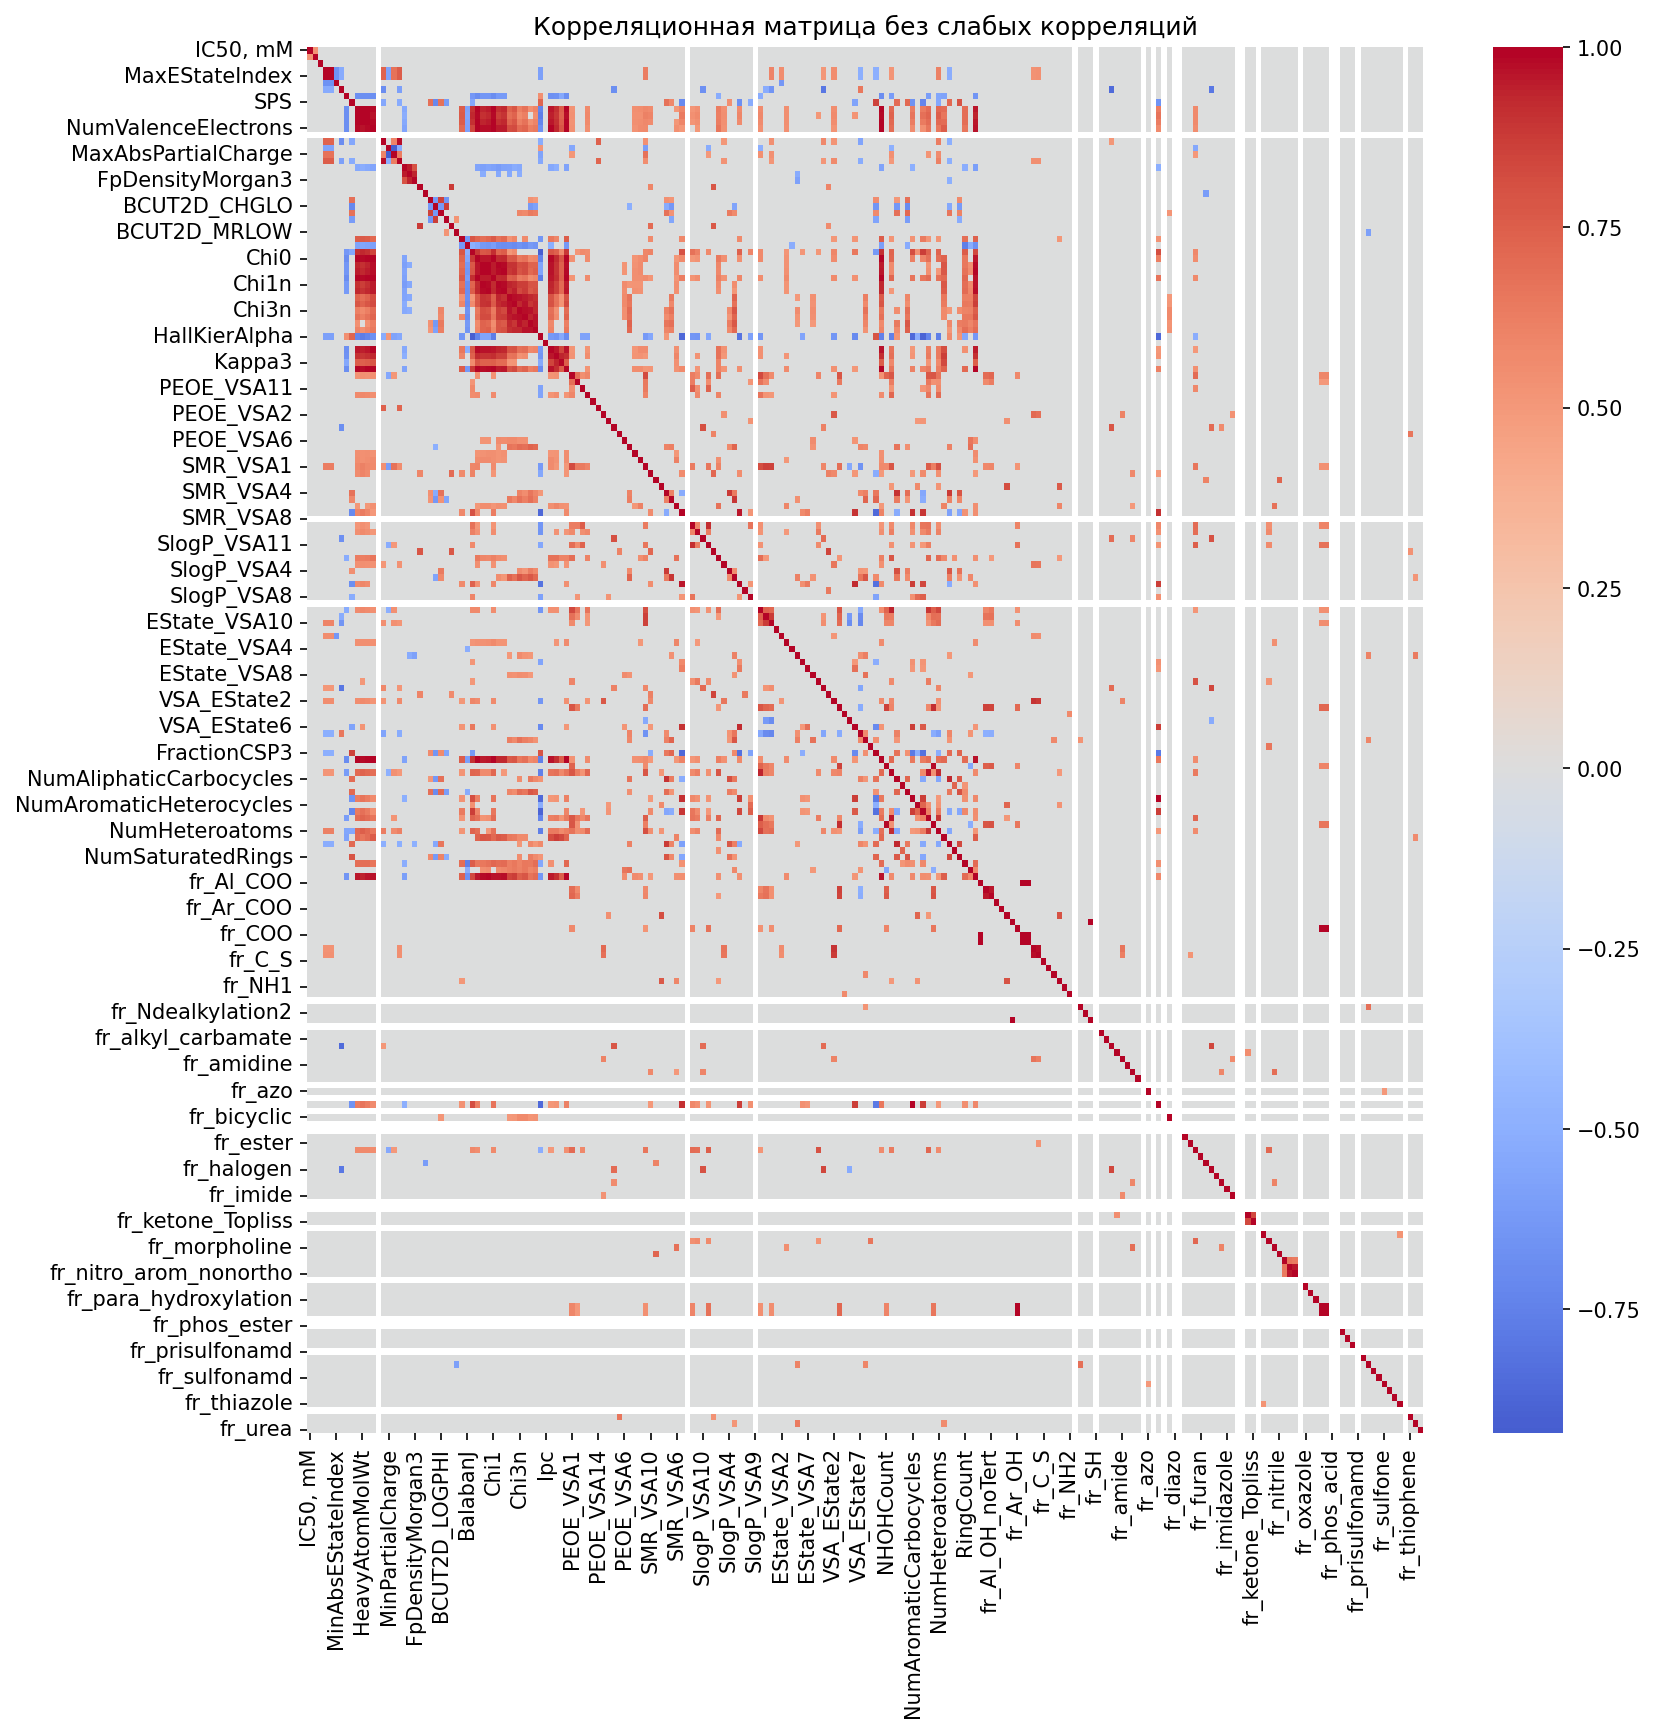

In [16]:
filtered_corr = data.corr().copy()
filtered_corr[abs(filtered_corr) < 0.5] = 0 #отсеяли все корреляции ниже 0.5

plt.figure(figsize=(12, 12), dpi=150)
sns.heatmap(filtered_corr, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица без слабых корреляций')
plt.show()

Ужасно читается.

Данные достаточно разнообразные: нет тотальной мультиколлинеарности


Но есть группы признаков, которые коррелируют сильно — их надо будет учитывать при построении моделей

Признаки типа Morgan, Chi, BCUT2D — наиболее информативны.

Удаление некоторых сильно коррелирующих блоков может уменьшить переобучение.

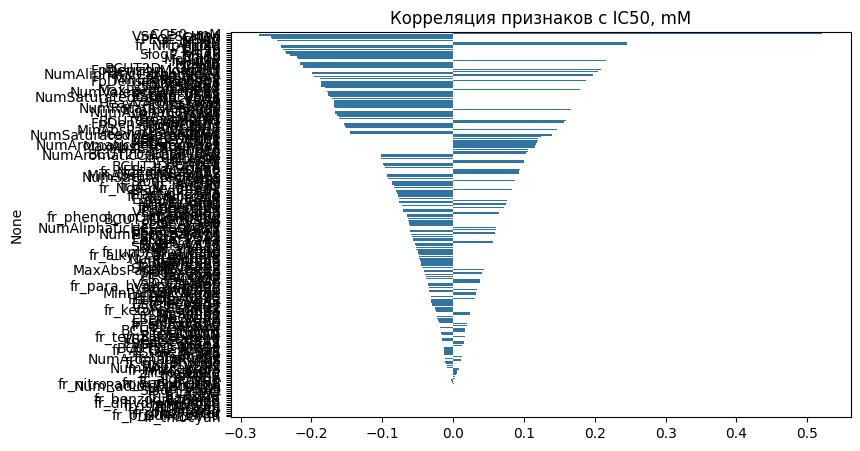

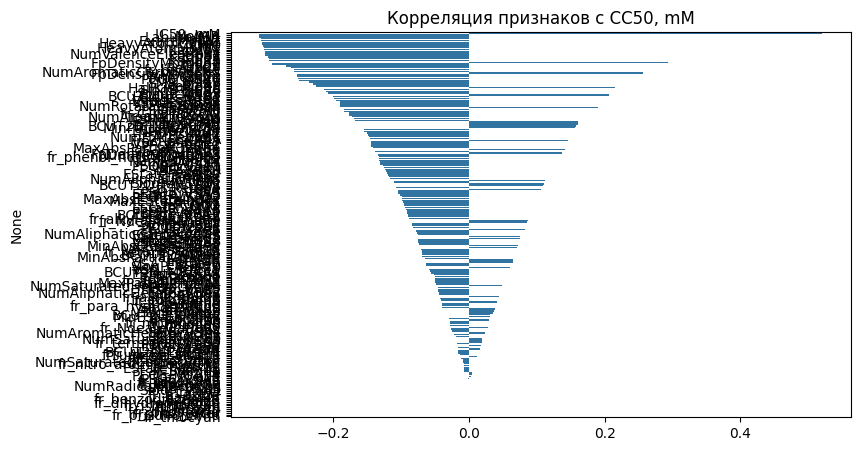

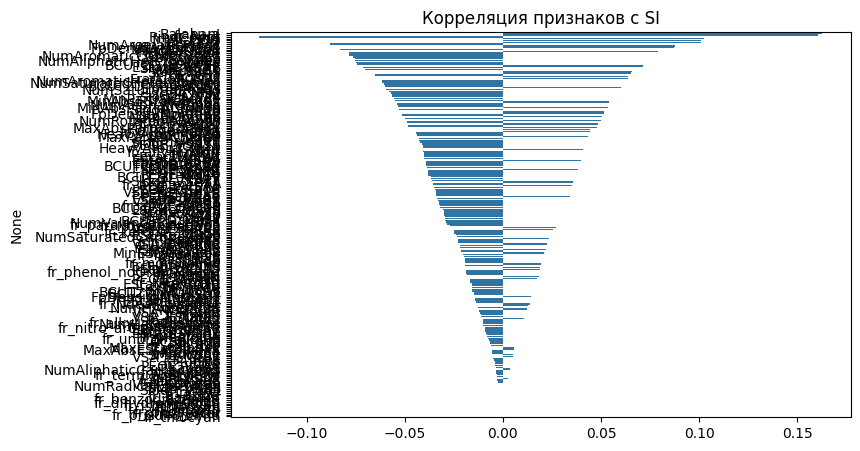

In [5]:
target_cols = ['IC50, mM', 'CC50, mM', 'SI']
for target in target_cols:
    correlations = data.corr()[target].drop(target).sort_values(key=abs, ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=correlations.values, y=correlations.index)
    plt.title(f'Корреляция признаков с {target}')
    plt.show()

Ужасно читается.

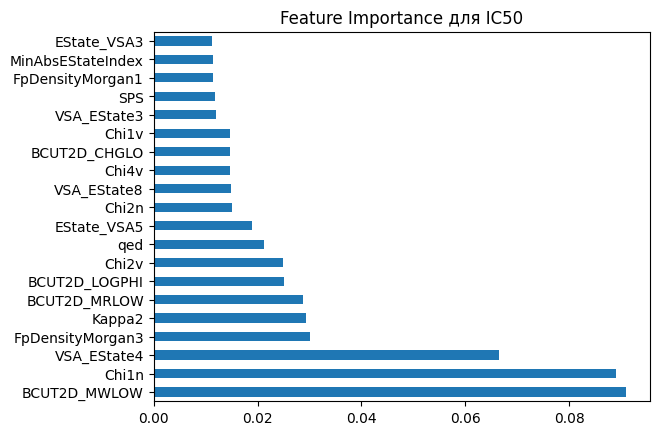

In [6]:
from sklearn.ensemble import RandomForestRegressor

X = data.drop(columns=['IC50, mM', 'CC50, mM', 'SI'])
y = data['IC50, mM']
rf = RandomForestRegressor()
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

importances.head(20).plot(kind='barh')
plt.title('Feature Importance для IC50')
plt.show()

Здесь видно, что наибольший вклад в предсказание IC50 вносят:

- BCUT2D_MWLOW

- Chi1n

- VSA_Estate4

- FpDensityMorgan3

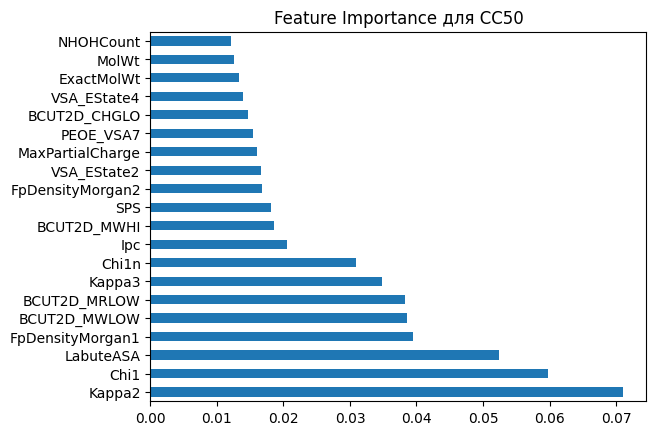

In [7]:
X = data.drop(columns=['IC50, mM', 'CC50, mM', 'SI'])
y = data['CC50, mM']
rf = RandomForestRegressor()
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

importances.head(20).plot(kind='barh')
plt.title('Feature Importance для CC50')
plt.show()

Самые важные признаки для CC50:

- Kappa2

- Chi1

- LabuteASA

- FpDensityMorgan1, Morgan1

- MolMR, BCUT2D_MWLOW

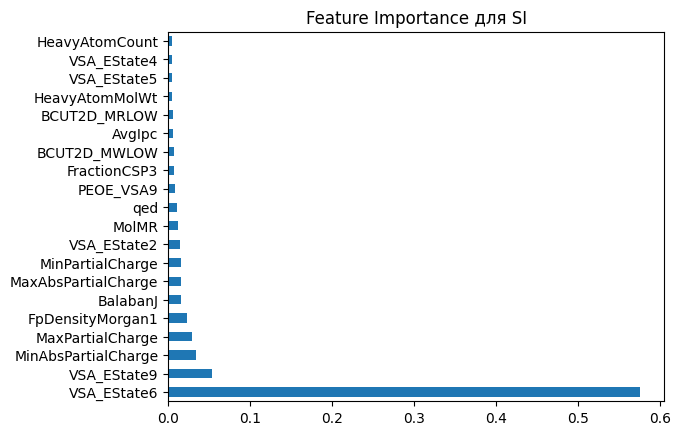

In [8]:
X = data.drop(columns=['IC50, mM', 'CC50, mM', 'SI'])
y = data['SI']
rf = RandomForestRegressor()
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

importances.head(20).plot(kind='barh')
plt.title('Feature Importance для SI')
plt.show()

Очень сильное доминирование признака для SI:

- VSA_Estate6

- FpDensityMorgan1

Удаление лишних и проверка мультиколлинеарности
---

In [9]:
# Проверим, есть ли признаки с почти полной корреляцией (например, >0.95)
cor_matrix = data.corr().abs()
upper = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.95)]

print("Сильно коррелирующие признаки (>0.95):", high_corr)

# Пока оставим все, но запомним для подбора моделей

Сильно коррелирующие признаки (>0.95): ['MaxEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MinAbsPartialCharge', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'Kappa1', 'Kappa2', 'LabuteASA', 'SlogP_VSA6', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors', 'MolMR', 'fr_Al_OH_noTert', 'fr_COO', 'fr_COO2', 'fr_C_O_noCOO', 'fr_Nhpyrrole', 'fr_benzene', 'fr_nitro_arom_nonortho', 'fr_phenol', 'fr_phenol_noOrthoHbond']


Стандартизация признаков
---

In [10]:
# Стандартизация только для регрессионных моделей (для классификаций отдельно обработаем)
features = data.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)